# Проведение исследования по теме наставничества 

## Описание проекта  и цель

Провести исследование по теме наставничества и менторства на основании контента социальной сети LinkedIn, размещенного в открытом доступе, созданного целевой аудиторией.

Определить топ-10 тем в направлении наставничества.

## Описание данных 

Сбор данных осуществлялся на сайт социальнй сети LinkedIN, в данных представлены ссылки на профили из ЦА, тексты публикаций.
Некоторые тексты были написаны на иностранных языках, поэтому они были предварительно переведены на русский.

 - url_user - ссылка на профиль
 - text_post  - текст публикации
 - language  - язык публикации
 - translated_text - переведенный текст

## План работы

1. Предобработка данных
 - Ознакомление с данными
 - Подготовка текстов
 - Векторизация текстов
2. Моделирование
 - LDA
 - Ключевые слова
 - Типичные статьи
3. Выводы

# 1. Предобработка данных

## Ознакомимся с данными

In [1]:
# Импорт библиотек
import re
import json
import warnings 

import pandas as pd
import numpy as np
import spacy
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')

In [2]:
# Устанавливаем необходимые библиотеки и качаем русскоязычную модель ru_core_news_sm.
# ! pip install spacy
# ! python -m spacy download ru_core_news_sm
# ! pip install matplotlib
# ! pip install nltk

In [6]:
# Ознакомимся с датасетом 
df = pd.read_csv('data/all_data_translated.csv')
df.head()

,url_user,text_post,language,translated_text
0,https://www.linkedin.com/in/korenevich/,['Приложение которое из голоса раскидывает зад...,ru,['Приложение которое из голоса раскидывает зад...
1,https://www.linkedin.com/in/korenevich/,'Почему основатель любого бизнеса обязан умет...,ru,'Почему основатель любого бизнеса обязан умет...
2,https://www.linkedin.com/in/korenevich/,'Казнить нельзя помиловать. Навык #9 – принят...,ru,'Казнить нельзя помиловать. Навык #9 – принят...
3,https://www.linkedin.com/in/korenevich/,"'Кто хорошо потрудился на этой неделе, тот я....",ru,"'Кто хорошо потрудился на этой неделе, тот я...."
4,https://www.linkedin.com/in/korenevich/,'Сегодня была защита дипломных работ на кафед...,ru,'Сегодня была защита дипломных работ на кафед...


In [7]:
df.shape

(11146, 4)

In [8]:
# Проверка на дубликаты
df.duplicated().sum()

211

In [9]:
# Удалим дубликаты 
df = df.drop_duplicates(keep='last')

In [10]:
df.isna().sum()

url_user           0
text_post          0
language           0
translated_text    0
dtype: int64

In [14]:
# Проверим есть ли строки, в которых нет текста
df.loc[df['translated_text'] == '']

,url_user,text_post,language,translated_text


In [12]:
# Количество профилей
df.url_user.nunique()

1012

In [15]:
# Посмотрим на тексты публикаций - случайным образом сэмплируем несколько примеров
for i in range(5):
    print(df['translated_text'].iloc[np.random.randint(len(df))])
    print()

Большие перспективы использования больших данных в образовании: примеры и преимущества. Большие данные имеют много преимуществ для образования, особенно в оптимизации дистанционного обучения. Он помогает учителям, предоставляя современные инструменты обучения, определяя интересный контент и позволяя им адаптировать свои методы обучения. Это также позволяет в режиме реального времени отслеживать успеваемость учащихся и анализировать академические результаты. Ознакомьтесь с полной статьей: https://lnkd.in/eHqMt4sT#education #edtech #schools #bigdata

 '- А я аналитик или вообще кто? А какой - продуктовый, бизнес, системный? Сколько я стою на рынке?- Я ничего не успеваю 🤯 чем больше делаю адхоков, тем больше беклог- За что хвататься? Чему учиться?!- Я вроде бы умный, а оффер не дают 😰- Заказчики заводят запросы как попало, все сторипойнты уходят на то, чтобы разобраться 😫 - Не знаю что дальше делать со своей карьерой- Мой сотрудник скилловее меня. Меня разоблачат? 😰Знакомо?С такими запрос

In [16]:
# Добавим дополнительнй признак - длина текста
df['len_text'] = df['text_post'].apply(lambda x:len(x))

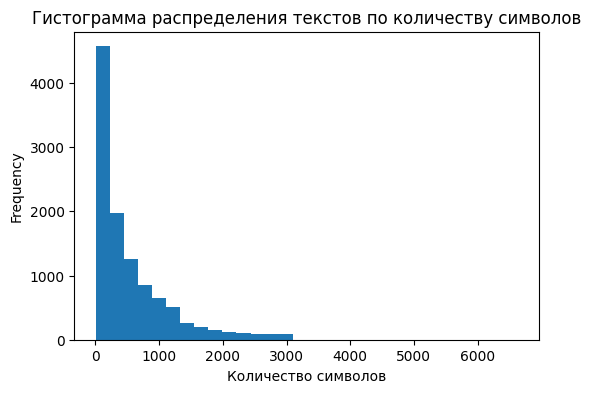

In [17]:
# Построим гистограмму распределения длин
plt.figure(figsize=(6,4))
df['len_text'].plot.hist(bins = 30)

plt.title('Гистограмма распределения текстов по количеству символов')
plt.xlabel('Количество символов')
plt.show()

In [18]:
df['len_text'].describe()

count    10935.000000
mean       545.891724
std        623.084776
min          2.000000
25%        110.500000
50%        307.000000
75%        762.000000
max       6638.000000
Name: len_text, dtype: float64

Видно, что длина некоторых текстов достигает 6638 знаков, а минамальная длина равна двум знакам. 25% данных короче 110 символов. Посмотрим на примеры текстов и оценим несут ли они в себе полезную информацию.

In [103]:
# Тексты короче 30 символов
df.loc[df['len_text'] < 30, 'translated_text']

91                    'оп и я тут тоже 😄
98           'Очень близок такой подход.
187                            'Хорошее)
209                      'Лучший способ!
210           'Будет что-нибудь сегодня?
                      ...               
11108    Умное производство — это круто.
11109                      Вперед, Илон!
11111        Дизайн базы данных DataCamp
11140                      Хорошая схема
11145                           DataCamp
Name: translated_text, Length: 780, dtype: object

In [22]:
# Тексты короче 100 символов
df.loc[df['len_text'] < 100, 'translated_text']

0        ['Приложение которое из голоса раскидывает зад...
3         'Кто хорошо потрудился на этой неделе, тот я....
5         '🔥Вот и приложение под iOS🔥 Очень ждал тк в м...
19                'Черканула о постановке карьерных целей.
29        'Пока мы на каникулах немного развлекательног...
                               ...                        
11133    Том Торн #нанимает. Знаете кого-нибудь, кому э...
11136    Посмотрите мое проверенное достижение от The L...
11140                                        Хорошая схема
11143         Обобщенные линейные модели DataCamp в Python
11145                                             DataCamp
Name: translated_text, Length: 2506, dtype: object

Удалим тексты короче 100 символов. Предполагаем, что это как правило текст, который не несет нужной нас информации - это может быть подпись к картинке или видео, набор хэштэгов и пр.

In [23]:
# Удалим наблюдения с текстами менее 100 символов
df_len_text_100 = df.loc[df['len_text'] > 100]

In [49]:
# Количество наблюдений
len(df_len_text_100)

8413

Размер датасета для анализа составляет **11238** строк на **6** столбцов. Представлены ссылки на профили пользователей, их имена, место работы, тексты публикаций и реакции на публикации.

Пропусков в данных нет, но есть дубликаты.
В текстах видны смайлы, хэштэги **(выделить в отдельный признак?)**, служебные символы, слова и абревиатуры на английском, ссылки. 

При анализе длины текстов выявлено, что **2591** текстов из **11238** "короткие" - т.е. их длина менее 100 символов.(**Используем их для анализа?**), из них 865 текстов короче 30 символов. Что составляет 23% и 8% от исходных данных. Попробуем удалить эти записи, так как они не несут в себе информации для анализа. Максимальныя длина текста - 6638 символов.

## Подготовка текстов

Теперь выполним токенизацию и лемматизацию текстов. Для этого будем использовать библиотеку [Spacy](https://spacy.io).
 Если выполнять обработку над каждым текстом по-отдельности, то это займёт достаточно много времени. Для ускорения применим "пакетную обработку" (batch processing).

In [24]:
model = spacy.load('ru_core_news_sm', disable=['ner', 'parser'])

In [25]:
# Складываем все тексты в один список
texts = df_len_text_100["translated_text"].tolist()

In [26]:
# Лемматизация текста для текстов, длиннее 100 символов
res = []
for doc in model.pipe(texts, disable=["tagger", "parser"]):
    try:
        res.append([token.lemma_ for token in doc])
    except:
        print(doc)

In [27]:
# Сохраним результат лемматизации
with open("lemmas_100.json", "w") as fid:
    json.dump({"lemmas": res}, fid)

In [35]:
# Смотрим на результат - случайным образом сэмплируем несколько примеров
for i in range(5):
    print(", ".join(res[np.random.randint(len(res))]))
    print()

прогрессивный, приложение, :, как, pwa, улучшать, пользовательский, опыт, ., выйти, онлайн, версия, статья, про, pwa.https://lnkd.in/dkggmnvf👉🏼, что, делать, ,, если, пользователь, не, хотеть, загружать, приложения?, 👉, 🏼, какой, компания, нужный, технология, pwa?, 👉, 🏼, как, улучшить, конверсия, с, помощь, прогрессивный, приложений?прогрессивные, веб, -, приложения, (, pwa, ), предлагать, высокопроизводительный, ,, ориентировать, на, мобильный, устройство, опыт, ,, сохранять, привлекательность, и, удобство, нативный, приложение, ., pwa, мочь, быть, загрузить, на, ", домашний, экран, ", клиент, и, магазин, приложение, ,, а, также, использовать, преимущество, нативный, кошелёк, для, упрощение, оплата, ., они, также, предлагать, возможность, отправка, уведомление, ,, что, являться, отличный, инструмент, вовлечение, пользователь, и, увеличение, продажа, ., pwa, быть, будущее, электронный, коммерция, ,, и, компания, ,, использовать, этот, технология, сейчас, ,, быть, выделяться, на, фон, к

Удалим знаки препинания, цифры и слова, содержащие цифры. А также иностранные слова. Для это соберём регулярное выражение, которое подходит для любого слова, состоящего из букв кирилицы.

In [36]:
word_pattern = re.compile("^[а-я]*$")

In [37]:
def remove_symbols(doc):
    return [token for token in doc if word_pattern.match(token)]

In [38]:
corpus = list(map(remove_symbols, res))

In [39]:
# Определим как часто встречаются к корпусе пустые списки (удалены все слова)
corpus_empty = [li for li in corpus if len(li) < 1]
len(corpus_empty)

14

In [40]:
# Смотрим на результат - случайным образом сэмплируем несколько примеров
for i in range(5):
    print(", ".join(corpus[np.random.randint(len(corpus))]))
    print()

привет, сеть, если, вы, заинтересованы, в, участие, в, ранний, доступ, к, наш, предстоящий, мобильный, игра, не, стесняться, присоединиться, к, список, ожидание, найти, ссылка, на, форма, в

хотеть, избежать, самых, распространенных, ошибка, основатель, стартап, мой, предстоять, статья, предлагать, пошаговый, объяснение, того, что, можно, и, что, нельзя, делать, если, вы, хотеть, создать, успешный, стартап, основать, на, мой, собственный, опыт, и, мнение, других, предприниматель, быть, готовый, через, день, основатель

здравствовать, сообщество, я, очень, рад, продемонстрировать, наш, последний, веб, дизайн, для, немецкий, бренд, предлагать, профессиональный, услуга, дрон, совмещать, эстетика, с, функциональность, чтобы, создавать, веб, сайты, которые, выглядеть, потрясающе, визуально, и, обеспечивать, беспрепятственный, пользовательский, интерфейс, продумать, веб, сайт, это, мощный, инструмент, для, компания, позволять, им, заявить, о, себя, в, интернет, и, добиться, значимый, результ

## Векторизация текстов

Теперь необходимо перевести тексты новостей и слова, из которых они состоят, в числовое представление, т.е. провести векторизацию при помощи Tf-iDf.

Чтобы уменьшить размерность получаемой матрицы, добавим исключение стоп-слов.

In [66]:
# Зададим собственный список стоп-слов
stop_words_custom = ['это', 'наш', 'ваш', 'весь', 'это', 'наш', 'лс', 'свой', 'весь', 'год', 'якщо', 'дуже', 'ви', 
                     'але', 'роботи', 'буде', 'це', 'ми', 'як', 'що', 'хто', 'чи', 'цей', 'зараз', 'хто', 'чи', 'цей', 'час',
                    'мария', 'эй']

In [67]:
# Дополнительные стоп-слова для руссковго языка
stop_words_additional = ["c","а","алло","без","белый","близко","более","больше","большой","будем","будет","будете","будешь",
                         "будто","буду","будут","будь","бы","бывает","бывь","был","была","были","было","быть","в","важная",
                         "важное","важные","важный","вам","вами","вас","ваш","ваша","ваше","ваши","вверх","вдали","вдруг",
                         "ведь","везде","вернуться","весь","вечер","взгляд","взять","вид","видел","видеть","вместе","вне",
                         "вниз","внизу","во","вода","война","вокруг","вон","вообще","вопрос","восемнадцатый","восемнадцать",
                         "восемь","восьмой","вот","впрочем","времени","время","все","все еще","всегда","всего","всем","всеми",
                         "всему","всех","всею","всю","всюду","вся","всё","второй","вы","выйти","г","где","главный","глаз",
                         "говорил","говорит","говорить","год","года","году","голова","голос","город","да","давать","давно",
                         "даже","далекий","далеко","дальше","даром","дать","два","двадцатый","двадцать","две","двенадцатый",
                         "двенадцать","дверь","двух","девятнадцатый","девятнадцать","девятый","девять","действительно","дел",
                         "делал","делать","делаю","дело","день","деньги","десятый","десять","для","до","довольно","долго",
                         "должен","должно","должный","дом","дорога","друг","другая","другие","других","друго","другое",
                         "другой","думать","душа","е","его","ее","ей","ему","если","есть","еще","ещё","ею","её","ж","ждать",
                         "же","жена","женщина","жизнь","жить","за","занят","занята","занято","заняты","затем","зато","зачем",
                         "здесь","земля","знать","значит","значить","и","иди","идти","из","или","им","имеет","имел","именно",
                         "иметь","ими","имя","иногда","их","к","каждая","каждое","каждые","каждый","кажется","казаться","как",
                         "какая","какой","кем","книга","когда","кого","ком","комната","кому","конец","конечно","которая",
                         "которого","которой","которые","который","которых","кроме","кругом","кто","куда","лежать","лет","ли",
                         "лицо","лишь","лучше","любить","люди","м","маленький","мало","мать","машина","между","меля","менее",
                         "меньше","меня","место","миллионов","мимо","минута","мир","мира","мне","много","многочисленная",
                         "многочисленное","многочисленные","многочисленный","мной","мною","мог","могу","могут","мож","может",
                         "может быть","можно","можхо","мои","мой","мор","москва","мочь","моя","моё","мы","на","наверху","над",
                         "надо","назад","наиболее","найти","наконец","нам","нами","народ","нас","начала","начать","наш","наша",
                         "наше","наши","не","него","недавно","недалеко","нее","ней","некоторый","нельзя","нем","немного",
                         "нему","непрерывно","нередко","несколько","нет","нею","неё","ни","нибудь","ниже","низко","никакой",
                         "никогда","никто","никуда","ним","ними","них","ничего","ничто","но","новый","нога","ночь","ну",
                         "нужно","нужный","нх","о","об","оба","обычно","один","одиннадцатый","одиннадцать","однажды",
                         "однако","одного","одной","оказаться","окно","около","он","она","они","оно","опять","особенно",
                         "остаться","от","ответить","отец","откуда","отовсюду","отсюда","очень","первый","перед","писать",
                         "плечо","по","под","подойди","подумать","пожалуйста","позже","пойти","пока","пол","получить",
                         "помнить","понимать","понять","пор","пора","после","последний","посмотреть","посреди","потом",
                         "потому","почему","почти","правда","прекрасно","при","про","просто","против","процентов","путь",
                         "пятнадцатый","пятнадцать","пятый","пять","работа","работать","раз","разве","рано","раньше",
                         "ребенок","решить","россия","рука","русский","ряд","рядом","с","с кем","сам","сама","сами","самим",
                         "самими","самих","само","самого","самой","самом","самому","саму","самый","свет","свое","своего",
                         "своей","свои","своих","свой","свою","сделать","сеаой","себе","себя","сегодня","седьмой","сейчас",
                         "семнадцатый","семнадцать","семь","сидеть","сила","сих","сказал","сказала","сказать","сколько",
                         "слишком","слово","случай","смотреть","сначала","снова","со","собой","собою","советский","совсем",
                         "спасибо","спросить","сразу","стал","старый","стать","стол","сторона","стоять","страна","суть",
                         "считать","т","та","так","такая","также","таки","такие","такое","такой","там","твои","твой","твоя",
                         "твоё","те","тебе","тебя","тем","теми","теперь","тех","то","тобой","тобою","товарищ","тогда","того",
                         "тоже","только","том","тому","тот","тою","третий","три","тринадцатый","тринадцать","ту","туда","тут",
                         "ты","тысяч","у","увидеть","уж","уже","улица","уметь","утро","хороший","хорошо","хотел бы","хотеть",
                         "хоть","хотя","хочешь","час","часто","часть","чаще","чего","человек","чем","чему","через","четвертый",
                         "четыре","четырнадцатый","четырнадцать","что","чтоб","чтобы","чуть","шестнадцатый","шестнадцать",
                         "шестой","шесть","эта","эти","этим","этими","этих","это","этого","этой","этом","этому","этот","эту",
                         "я","являюсь"]

In [68]:
# Объединим стоп-слова
stop_words = stopwords.words('russian') + stop_words_custom + stop_words_additional
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [128]:
# Посчитаем IDF всех наших слов, и отсечем слова с самым большим idf(очень редкие) и с самым маленьким
tfidf = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.9)

In [129]:
# Объединим списки слов в предложения
docs = [" ".join(tokens) for tokens in corpus]
docs[:3]

['почему основатель любой бизнес обязанный уметь продавать навык продажа десяток стартап проплывать у меня перед глаз каждый месяц кто то приходить за разовый совет кто то с просьба о долгосрочный сотрудничество каждый новый встреча для меня уникальный и я всегда с свой сторона стараться подготовиться посмотреть проект рынок конкурент каждый встреча ждать с нетерпение ждать потому что увидеть новый проект новый идея новый человек который хотеть изменить этот мир к хороший понимать что это нифига не просто и естественно я рассчитывать что этот человек продать мне свой идея ярко рассказать о свой проект команда о свой победа и конечно же трудность человек который уметь продавать видно с первый минута разговор я хотеть обратить внимание на то что именно продавать а не машинальный впаривать по ранее заготовить скрипт такой фаундеры выделяться среди других они запоминаться и сказать по секрет я наблюдать за многими из них даже если запрос фаундера не совпадать с мой компетенция и мы больше 

In [130]:
x = tfidf.fit_transform(docs)

In [131]:
x.shape

(8413, 4011)

Теперь составим словарь {id_токена: токен} - он пригодится нам позднее.

In [132]:
id2word = {i: token for i, token in enumerate(tfidf.get_feature_names_out())}

# 2.Моделирование

## LDA

In [133]:
# Зададим количество тем
n_topics = 10

In [134]:
lda = LatentDirichletAllocation(n_components=n_topics,
                                max_iter=30,
                                random_state=31)

In [135]:
topics = lda.fit_transform(x)

In [136]:
topics.shape

(8413, 10)

Получили массив размера **8414x10**. Строки здесь - отдельные тексты, а колонки - 10 выделенных тем. В каждой ячейке стоит вероятность того, что данный текст относится к данной теме. 

## Ключевые слова

Теперь извлечём ключевые слова для каждой из 10 тем. В свойсте components _ лежит матрица соответствия слов темам. Пройдёмся по каждой из 20 выделенных тем и для каждой возьмём ТОП-20 слов.

In [137]:
for i in range(n_topics):
    c = lda.components_[i, :]
    topic_tokens = [id2word.get(token_id) for token_id in np.argsort(c)[-10:]]
    print("Тема",i, ":")
    print(", ".join(topic_tokens))
    print("\n ")

Тема 0 :
создать, фирменный, анимация, пожаловать, сайт, добро, дизайнер, стиль, логотип, дизайн

 
Тема 1 :
военный, европа, доклад, вебинар, ноябрь, март, российский, конференция, украинец, украина

 
Тема 2 :
желать, счастливый, выходной, справляться, проверка, пройти, тест, следующий, значок, навык

 
Тема 3 :
рад, услуга, разработка, сообщить, сертификат, компания, должность, начинать, удовольствие, сообщать

 
Тема 4 :
английский, команда, поиск, проект, привет, опыт, резюме, разработчик, искать, вакансия

 
Тема 5 :
решение, опыт, клиент, приложение, продукт, бизнес, разработка, команда, проект, компания

 
Тема 6 :
асинхронный, машинный, буква, испытание, карусель, видео, генеративный, проверить, курс, закончить

 
Тема 7 :
делиться, статья, желать, тильда, оценить, комментарий, праздник, ребята, нанимать, лендинг

 
Тема 8 :
кибербезопасность, здравствовать, признателен, иб, поддержка, совет, предложить, возможность, заранее, благодарить

 
Тема 9 :
встретиться, отличный, нете

По полученным ключевым словам можно составить представление о содержании той или иной темы.

## Типичные статьи

Теперь для каждой темы возьмём по одному документу, который хорошо соответсвует этой теме. Для этого заглянем в массив _topics_.

In [138]:
for i in range(n_topics):
    doc_id = np.argmax(topics[:, i])
    print("Тема ", i)
    print(df_len_text_100.iloc[doc_id]["translated_text"])
    print("\n")

Тема  0
Привет, ребята 👋🏼Хотим поделиться с вами одним из наших проектов -👉 https://lnkd.in/dCdDrEbmЧто вы думаете об этом дизайне? Делитесь своими мыслями в комментариях 💬✉️ Есть идея проекта? Я доступен для новых проектов yehor.haiduk@gmail.com или телеграмм-чат🔥 Отметьте своего друга, которому это нравится 😉👉 Посетите нашу страницу и не забудьте подписаться на другие дизайнерские материалы, подобные этому! Проверьте больше работ здесь https: //lnkd.in/g-2DSu5


Тема  1
Привет сообщество, Этой весной русские вторглись в мою прекрасную страну. Наш дом. Они украли у многих людей дома или разрушили их. Один из этих домов был домом моей крестной матери. Русские ракеты разрушают крышу и большую часть интерьера. Вот ссылка на пожертвование, организованное ее подругой Ольгой для восстановления дома. https://lnkd.in/dYriH-6KP.s. вчера был мой день рождения и лучший подарок, который вы можете сделать, это поделиться этой ссылкой🙏


Тема  2
['Провожу сегодня коуч-сессии в Международной академи

In [92]:
# Добавим столбец с номером темы для каждого наблюдения
df_len_text_100['topic'] = topics.argmax(axis=1)
df_len_text_100.head()

,url_user,text_post,language,translated_text,len_text,topic
1,https://www.linkedin.com/in/korenevich/,'Почему основатель любого бизнеса обязан умет...,ru,'Почему основатель любого бизнеса обязан умет...,2973,5
2,https://www.linkedin.com/in/korenevich/,'Казнить нельзя помиловать. Навык #9 – принят...,ru,'Казнить нельзя помиловать. Навык #9 – принят...,2975,5
4,https://www.linkedin.com/in/korenevich/,'Сегодня была защита дипломных работ на кафед...,ru,'Сегодня была защита дипломных работ на кафед...,1044,5
6,https://www.linkedin.com/in/korenevich/,'Кто я? Чем занимаюсь? Чем и кому могу быть п...,ru,'Кто я? Чем занимаюсь? Чем и кому могу быть п...,2576,5
7,https://www.linkedin.com/in/korenevich/,"'Казалось бы, ну какая нам разница, где и как...",ru,"'Казалось бы, ну какая нам разница, где и как...",2034,5


In [93]:
# Определим какие темы представлены чаще всего
df_len_text_100['topic'].value_counts()

topic
5    6440
4     611
1     262
8     206
0     191
3     186
9     180
2     151
7     128
6      58
Name: count, dtype: int64

In [94]:
# Добавим столбец с вероятностью принадлежности выбранной теме для каждого наблюдения
df_len_text_100['probability'] = topics.max(axis=1)
df_len_text_100.head()

,url_user,text_post,language,translated_text,len_text,topic,probability
1,https://www.linkedin.com/in/korenevich/,'Почему основатель любого бизнеса обязан умет...,ru,'Почему основатель любого бизнеса обязан умет...,2973,5,0.892328
2,https://www.linkedin.com/in/korenevich/,'Казнить нельзя помиловать. Навык #9 – принят...,ru,'Казнить нельзя помиловать. Навык #9 – принят...,2975,5,0.887968
4,https://www.linkedin.com/in/korenevich/,'Сегодня была защита дипломных работ на кафед...,ru,'Сегодня была защита дипломных работ на кафед...,1044,5,0.852275
6,https://www.linkedin.com/in/korenevich/,'Кто я? Чем занимаюсь? Чем и кому могу быть п...,ru,'Кто я? Чем занимаюсь? Чем и кому могу быть п...,2576,5,0.843143
7,https://www.linkedin.com/in/korenevich/,"'Казалось бы, ну какая нам разница, где и как...",ru,"'Казалось бы, ну какая нам разница, где и как...",2034,5,0.878255


In [101]:
# Выберем топ-100 текстов с максимальной вероятностью
top_100 = df_len_text_100[['translated_text', 'topic', 'probability']].sort_values(by = 'probability', 
                                                                                   ascending  = False).iloc[:100]
top_100

,translated_text,topic,probability
7226,Часть 1. Недавно Airkod выпустила бета-версию ...,5,0.926867
6042,📚 В Национальный день благодарности учителям м...,5,0.920079
4374,Продукты становятся более медийными и менее те...,5,0.920073
4552,Топ-7 полезных инструментов для организации ра...,5,0.918085
8771,"Привет народ! Вы задавались вопросом, чего не ...",5,0.917325
...,...,...,...
2419,В IT среде часто говорят о недопустимости токс...,5,0.895096
7285,Пришло время рассмотреть возможности технологи...,5,0.894960
6512,"🧐 Что вы знаете о кибербезопасности? Возможно,...",5,0.894937
6535,Основные функции CRM для танцевальной школы: C...,5,0.894703


In [102]:
top_100.topic.value_counts()

topic
5    100
Name: count, dtype: int64

Алгоритм увереннее всего определяет пятую тему, что логично, так как именно эта тема представлена максимально (6440 текстов)

In [148]:
# Попробуем оценить насколько уверен алгоритм в остальных темах
df_len_text_100.groupby('topic').agg({'probability' : 'mean', 
                                      'topic' : 'count'}).sort_values(by = 'probability', ascending = False)

,probability,topic
topic,,
5,0.748112,6440
8,0.707846,206
6,0.656329,58
3,0.651682,186
7,0.632954,128
9,0.627983,180
4,0.607980,611
2,0.602933,151
1,0.571736,262


Лучшие по средней вероятности темы - 5, 8, 6 (**дописать примерные названия тем**), не смотря на то, что 6 тема представлена только в 58 текстах. А вот 2, 1 и 0 темы определяются хуже всего.
**дополнить вывод - почему так**

Попробуем использовать распределения тем в тексте как 'эмбеддинги' текстов, в такой интерпретации можно применять к ним алгоритмы визуализации или кластеризации, и искать уже итоговые 'эффективные ' тематические кластеры таким образом.

In [82]:
kmeans = KMeans(n_clusters=10)

clust_labels = kmeans.fit_predict(topics)
clust_centers = kmeans.cluster_centers_

embeddings_to_tsne = np.concatenate((topics,clust_centers), axis=0)

# TSNE это инструмент для визуализации многомерных данных
tSNE =  TSNE(n_components=2, perplexity=15)
tsne_embeddings = tSNE.fit_transform(embeddings_to_tsne)
tsne_embeddings, centroids_embeddings = np.split(tsne_embeddings, [len(clust_labels)], axis=0)

In [83]:
clust_indices = np.unique(clust_labels)

clusters = {clust_ind : [] for clust_ind in clust_indices}
for emb, label in zip(tsne_embeddings, clust_labels):
    clusters[label].append(emb)

for key in clusters.keys():
    clusters[key] = np.array(clusters[key])
    
colors = cm.rainbow(np.linspace(0, 1, len(clust_indices)))

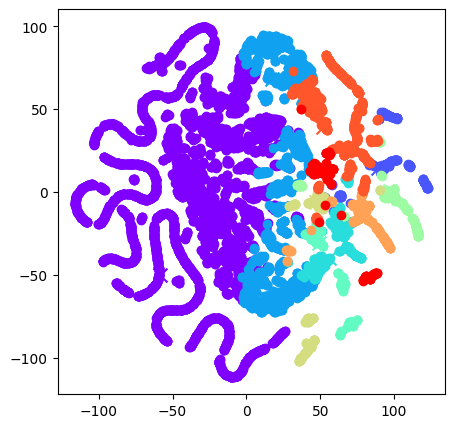

In [149]:
plt.figure(figsize=(5,5))
for ind, color in zip(clust_indices, colors):
    x = clusters[ind][:,0]
    y = clusters[ind][:,1]
    plt.scatter(x, y, color=color)
    
    centroid = centroids_embeddings[ind]
    plt.scatter(centroid[0],centroid[1], color=color, marker='x', s=100)

plt.show()

Тут хотелось бы написать, что на изображении TSNE ембеддингов, видно, что кластеры выделенные с помощью KMeans, образуют достаточно связные и чаще всего пространственно разделимые между собой множества. Но на самом деле видно, что есть над чем еще поработать.

# 3.Выводы

Для проведения исследования командой написан парсер для сбора данных в социальной сети LinkedIN, которые представляют собой ссылки на профили людей, подходящих под ЦА заказчика, тексты их постов и реакции.

Получилось собрать информацию о 158 профилях и 1125 текстов. Преобладающее количество текстов на русском языке. Но из-за небольшого их количества выполнить задачу не представлялось возможным. Поэтому, для улучшения качества прогноза модели, было решено обменяться собранными данными с другими командами.

**В итоге в анализе использовались 1017 профилей и 11238 текстов.** Полученные тексты распределились по языкам следующим образом:
 - en - 60%
 - ru - 32%
 - uk - 2%
 - остальные - 6% (всего определлились 36 языков).
Для крректного анализа тексты были предварительно переведены на русский язык.

При исследовании длинн полученных текстов установлено, что она достигает 6638 знаков, а минамальная длина равна двум знакам. Таким образом, 25% собранных данных короче 110 символов. Такие "короткие" тексты (предположительно подпись к картинке или видео, набор хэштэгов, смайлов и пр.) не несли в себе полезную информацию, поэтому решено было удалить эти наблюдения. В итоге использовались 8413 текстов.

На этапе подготовки текстов для модели была проведена лемматизация и токенизация текстов. Так же тексты были очищены от "мусорных" символов - знаков пунктуации, смайлов, иностранных слов, цифр. Удалены стоп слова. 

Векторизация текстов производилась при помощи Tf-iDf.
На этапе подбора модели были использованы:
 - LDA - LatentDirichletAllocation
 - NMF - Non-Negative Matrix Factorization

Эффективность работы модели сложно оценить, так как нет метрик на которые можно опереться. Для выбора модели использовали здравый смысл и алгоритмы визуализации, которые позволили определить насколько хорошо модель разделяет тесты по темам.

Корректное распределение вероятности и лучшее разделение тем получено в результате применения модели LDA. Таким образом, рейтинг тем на основании частоты упоминания в порядке убивания:

 - Тема 6 - новости IT рынка;
 - Тема 9 - поиск работы;
 - Тема 7 - обучение IT профессиям;
 - Тема 4 - предложение IT услуг;
 - Тема 8 - IT рекрутмент;
 - Тема 10 - поиск работы;
 - Тема 5 - менторство начинающих специалистов;
 - Тема 3 - коучинг;
 - Тема 2 - внешняя политика;
 - Тема 1 - проектное сотрудничество;
 
На основании полученных результатов можно заметить, что все посты написаны примерно про одно и то же, это: поиск работы или работников, впечатление от обучения и несколько тем посвящены коучингу и менторству начинающих специалистов. По теме наставничества целевая группа пишет немного.

**Пример визуализации разделения тем на кластеры моделью LDA**
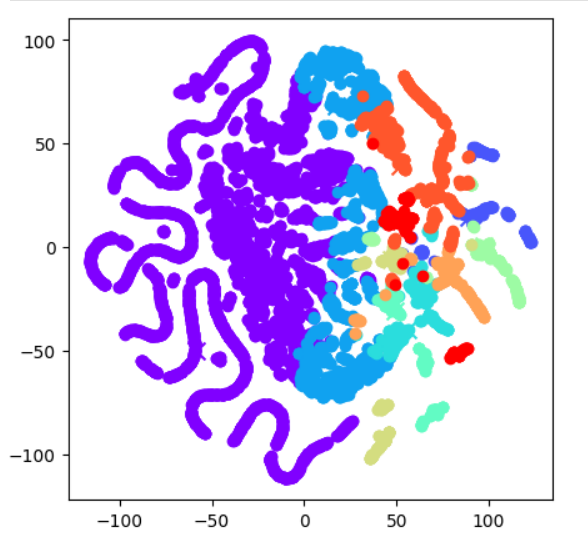
На изображении tSNE ембеддингов, видно, что кластеры выделенные с помощью KMeans, образуют достаточно связные и чаще всего пространственно разделимые между собой множества. Но так же видно, что есть над чем еще поработать.

При анализе распределения тем, с большим отрывом лидирует тема 6 (6440 текстов), на втором месте модель поставила тему 5 - 611 текстов, на третьем - 2 тема и 262 текста.

При оценке топ-100 постов, для которых модель наиболее уверенно (с большей вероятностью) определила тему выяснилось, что все эти посты отнесены к теме 6. Что логично, так как эти тексты представлены на порядок в большем количестве. Вероятность для топ-100 находится в пределах 0.92 - 0.89.

При оценке средней вероятности, с которой алгоритм определял принадлежность к определенной теме выяснилось, что увереннее всего он справляется с темами:
 - 6 тема - средняя вероятность 0.75 - количество текстов 6440
 - 9 тема - средняя вероятность 0.71 - количество текстов 206
 - 7 тема - средняя вероятность 0.66 - количество текстов 58
Хуже всего модель справилась с темами 3, 2 и 1 - средние вероятности 0.60 (151 текст), 0.57(262) и 0.56(191). Возможно, это связано с тебольшим количеством текстов для данных тем.


**Что можно сдлеать лучше:**
- Изменить стратегию поиска постов - парсить не все данные, а именно ЦА. Так получим посты на нужную тематику, котрые модель лучше сможет разделить на темы.
- Хороший результат был получен при добавлении стоп кастомизированных стоп-слов, расширение этого списка потенциально может улучшить работу модели.
- Попробовать использовать предобученные модели BERT как самостоятельный вариант или вместе с LDA.

**Сложности с которыми столкнулись в процессе парсинга - **

| Тема | Название темы | Количество тем |Средняя вероятность | Ключевые слова |
|----------|----------|----------|----------|----------|
| Тема 6    | новости IT рынка   | 6440 | 0.75 | решение, опыт, клиент, приложение, продукт, бизнес, разработка, команда, проект, компания |
| Тема 9    | поиск работы   | 206 | 0.71 | кибербезопасность, здравствовать, признателен, иб, поддержка, совет, предложить, возможность, заранее, благодарить |
| Тема 7    | обучение IT профессиям   | 58 | 0.66 | асинхронный, машинный, буква, испытание, карусель, видео, генеративный, проверить, курс, закончить |
| Тема 4    | предложение IT услуг   | 186 | 0.65 | рад, услуга, разработка, сообщить, сертификат, компания, должность, начинать, удовольствие, сообщать |
| Тема 8    | IT рекрутмент   | 128 | 0.63 | делиться, статья, желать, тильда, оценить, комментарий, праздник, ребята, нанимать, лендинг |
| Тема 10   | поиск работы    | 180 | 0.63 | встретиться, отличный, нетерпение, невероятный, поделиться, грузия, команда, заявка, рад, саммит |
| Тема 5    | менторство начинающих специалистов   | 611 | 0.61 | английский, команда, поиск, проект, привет, опыт, резюме, разработчик, искать, вакансия |
| Тема 3    | коучинг   | 151 | 0.60 | желать, счастливый, выходной, справляться, проверка, пройти, тест, следующий, значок, навык |
| Тема 2    | внешняя политика   | 262 | 0.57 | военный, европа, доклад, вебинар, ноябрь, март, российский, конференция, украинец, украина |
| Тема 1    | проектное сотрудничество   | 191 | 0.56 | создать, фирменный, анимация, пожаловать, сайт, добро, дизайнер, стиль, логотип, дизайн |